In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arff
import numpy as np
from statsmodels.api import OLS
from patsy import dmatrices

In [2]:
data_freq = arff.load('data/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", 
                                           "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])

data_sev = arff.load('data/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

### Explorative Datenanalyse und Feature Engineering

In [3]:
len(df_freq), len(df_sev)

(678013, 26639)

In [4]:
df_freq.head()


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
1,3.0,1.0,0.77,'D',5.0,0.0,55.0,50.0,'B12',Regular,1217.0,'R82'
2,5.0,1.0,0.75,'B',6.0,2.0,52.0,50.0,'B12',Diesel,54.0,'R22'
3,10.0,1.0,0.09,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'
4,11.0,1.0,0.84,'B',7.0,0.0,46.0,50.0,'B12',Diesel,76.0,'R72'


In [3]:
df_freq.head()

# remove quation marks from string columns -> VehGas already OK
string_columns = ["VehBrand", "Region", "Area"]
for col in string_columns:
    df_freq[col] = df_freq[col].str.strip("'")

df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [6]:
df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


In [7]:
df_sev.isna().sum()

IDpol          0
ClaimAmount    0
dtype: int64

In [8]:
df_freq.isna().sum()

IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64

In [21]:
# check for duplicate IDs
print(df_freq['IDpol'].duplicated().any())

False


In [9]:
# check if all IDs in df_sev are in df_freq
df_sev[~df_sev['IDpol'].isin(df_freq['IDpol'])]['IDpol'].nunique()

6

In [4]:
# check if claim counts are correct in df_freq
accident_counts = df_sev.groupby('IDpol').count().rename(columns={'ClaimAmount': 'ClaimNbCalculated'}).sort_values(by='ClaimNbCalculated', ascending=False).reset_index()
accident_counts

,IDpol,ClaimNbCalculated
0,2262511.0,66
1,2282134.0,36
2,2227533.0,25
3,2220367.0,24
4,2277846.0,23
...,...,...
24945,1162674.0,1
24946,1162669.0,1
24947,1162656.0,1
24948,1162652.0,1


In [5]:
df_sev_summed = df_sev.groupby('IDpol').sum().reset_index()
df_sev_summed = pd.merge(df_sev_summed, accident_counts, on='IDpol')
df_merged = pd.merge(df_freq, df_sev_summed, on='IDpol', how='left') # left join to keep contracts without claims

In [6]:
print('Number of contracts with no claims:', df_merged['ClaimAmount'].isna().sum())
df_merged['ClaimAmount'] = df_merged['ClaimAmount'].fillna(0)
df_merged['ClaimNbCalculated'] = df_merged['ClaimNbCalculated'].fillna(0)

Number of contracts with no claims: 653069


In [16]:
print(np.mean(df_merged['ClaimNb'] != df_merged['ClaimNbCalculated'])) # some claim counts are different

0.013446644828344


In [9]:
# descriptive statistics -> full dataset

num_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimAmountPerYear']

df_merged['ClaimAmountPerYear'] = df_merged['ClaimAmount'] / df_merged['Exposure']

round(df_merged[num_cols + ['ClaimNbCalculated', 'Exposure']].describe([.001, .01, .25, .5, .75, .99, .999]).iloc[1:, :], 2)

,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmountPerYear,ClaimNbCalculated,Exposure
mean,6.45,7.04,45.50,59.76,1792.42,383.26,0.04,0.53
std,2.05,5.67,14.14,15.64,3958.65,36820.70,0.21,0.36
min,4.00,0.00,18.00,50.00,1.00,0.00,0.00,0.00
0.1%,4.00,0.00,18.00,50.00,5.00,0.00,0.00,0.00
1%,4.00,0.00,20.00,50.00,10.00,0.00,0.00,0.01
25%,5.00,2.00,34.00,50.00,92.00,0.00,0.00,0.18
50%,6.00,6.00,44.00,50.00,393.00,0.00,0.00,0.49
75%,7.00,11.00,55.00,64.00,1658.00,0.00,0.00,0.99
99%,13.00,21.00,80.00,106.00,27000.00,3081.21,1.00,1.00
99.9%,15.00,33.00,89.00,132.00,27000.00,35632.68,2.00,1.03


In [11]:
# descriptive statistics -> only contracts with claims

round(df_merged[df_merged['ClaimNbCalculated'] > 0][num_cols + ['ClaimNbCalculated', 'Exposure']].describe([.001, .01, .25, .5, .75, .99, .999]).iloc[1:, :], 2)

,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmountPerYear,ClaimNbCalculated,Exposure
mean,6.47,7.39,45.14,64.93,1984.31,10417.57,1.06,0.69
std,2.01,5.17,14.66,19.86,4119.72,191698.89,0.29,0.31
min,4.00,0.00,18.00,50.00,2.00,1.00,1.00,0.00
0.1%,4.00,0.00,18.00,50.00,5.00,7.67,1.00,0.01
1%,4.00,0.00,19.00,50.00,10.00,53.27,1.00,0.04
25%,5.00,3.00,34.00,50.00,111.00,1128.00,1.00,0.45
50%,6.00,7.00,45.00,55.00,495.00,1504.16,1.00,0.76
75%,7.00,11.00,54.00,76.00,2120.00,3352.01,1.00,1.00
99%,13.00,20.00,81.00,125.00,27000.00,110888.54,2.00,1.00
99.9%,15.00,30.00,89.00,156.00,27000.00,1113919.73,3.00,1.07


In [12]:
# case with highest claim amount

df_merged[df_merged['ClaimAmount'] == max(df_merged['ClaimAmount'])]

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimNbCalculated,ClaimAmountPerYear
150027,1120377.0,1.0,0.22,B,9.0,13.0,19.0,100.0,B2,Regular,93.0,R24,4075400.56,1.0,18524548.0


In [13]:
df_merged[(df_merged['VehBrand'] == 'B2') & (df_merged['ClaimAmount'] > 0)]['ClaimAmount'].nlargest(10)

150027    4075400.56
270621    1301172.60
135927     255013.03
298185     241171.16
408197     209695.87
389646     208472.60
121527     205432.05
25274      183073.66
447569     182500.00
399662     182050.00
Name: ClaimAmount, dtype: float64

In [14]:
# drop outliers with very large claim amounts -> not enough data to model them
df_merged = df_merged[df_merged['ClaimAmountPerYear'] < 100_000].reset_index(drop=True)

In [12]:
# sns.pairplot(df_merged[num_cols]);

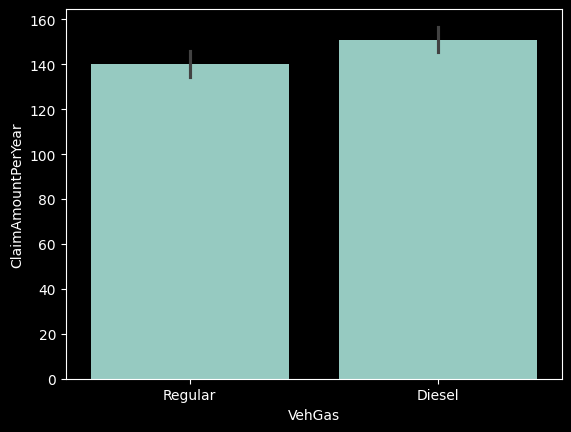

In [13]:
# bar plot ClaimAmountPerYear by VehGas
# df_merged.groupby('VehGas')['ClaimAmountPerYear'].mean().plot.bar()

# add confidence intervals
sns.barplot(x='VehGas', y='ClaimAmountPerYear', data=df_merged, errorbar=('ci', 95));

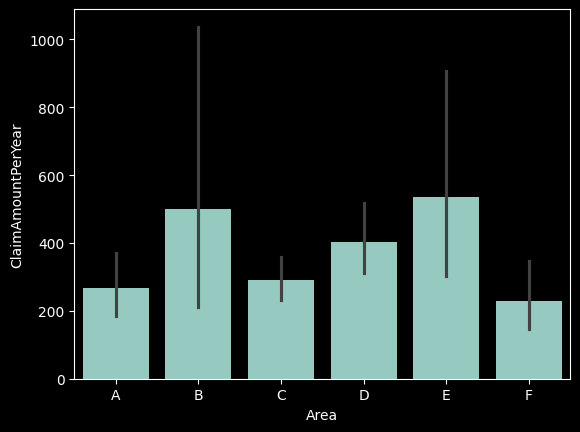

In [32]:
sns.barplot(x='Area', y='ClaimAmountPerYear', data=df_merged.sort_values('Area'), errorbar=('ci', 95));

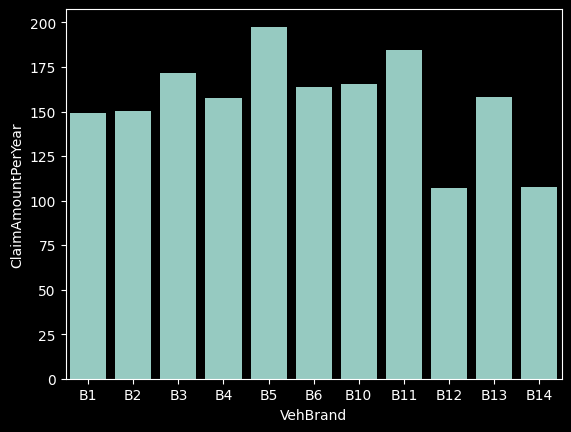

In [40]:
sns.barplot(x='VehBrand', y='ClaimAmountPerYear', data=df_merged.sort_values('VehBrand', key=lambda x: x.str.lstrip('B').astype(int)), errorbar=None);

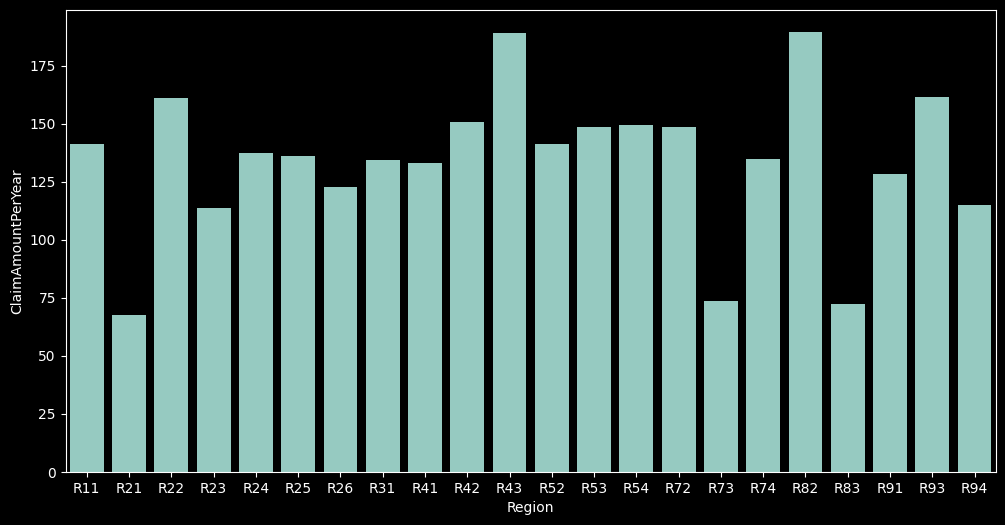

In [41]:
plt.figure(figsize=(12,6))
sns.barplot(x='Region', y='ClaimAmountPerYear', data=df_merged.sort_values('Region', key=lambda x: x.str.lstrip('R').astype(int)), errorbar=None);

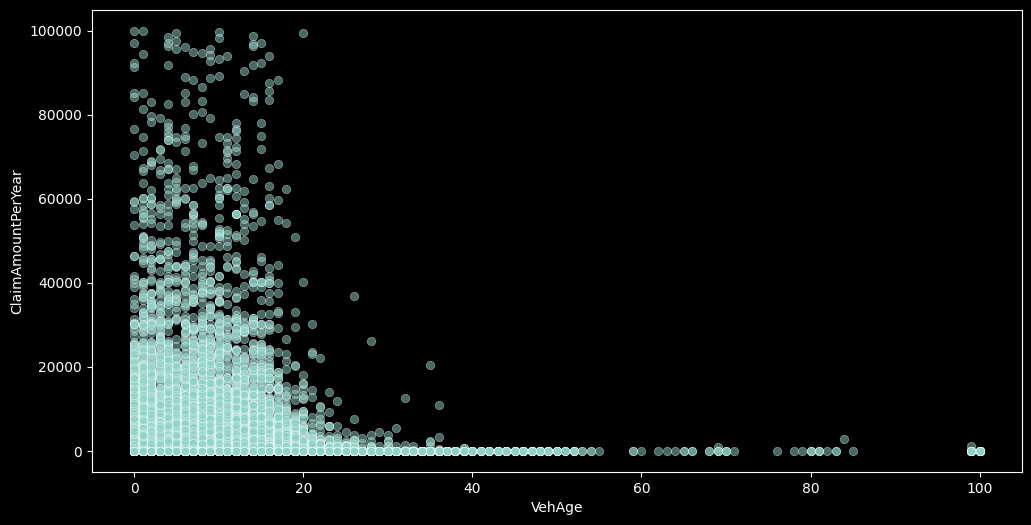

In [33]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='VehAge', y='ClaimAmountPerYear', data=df_merged, alpha=0.5);

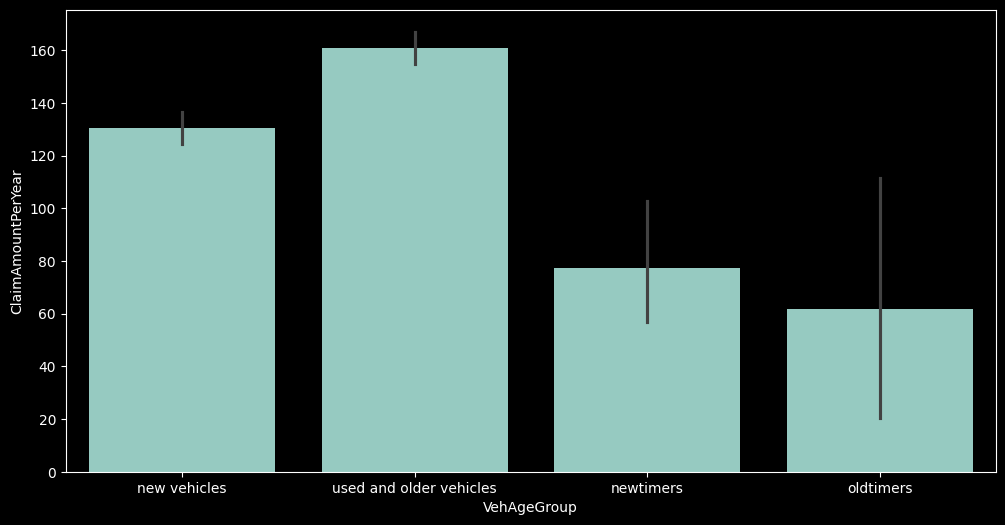

In [24]:
plt.figure(figsize=(12,6))
df_merged['VehAgeGroup'] = pd.cut(df_merged['VehAge'], [0, 5, 20, 30, max(df_merged['VehAge'])], include_lowest=True,
                                  labels=['new vehicles', 'used and older vehicles', 'newtimers', 'oldtimers'],  precision=0)
ax = sns.barplot(x='VehAgeGroup', y='ClaimAmountPerYear', data=df_merged);

In [37]:
# df_merged['logClaimAmountPerYear'] = np.log(df_merged['ClaimAmountPerYear'] + 1)

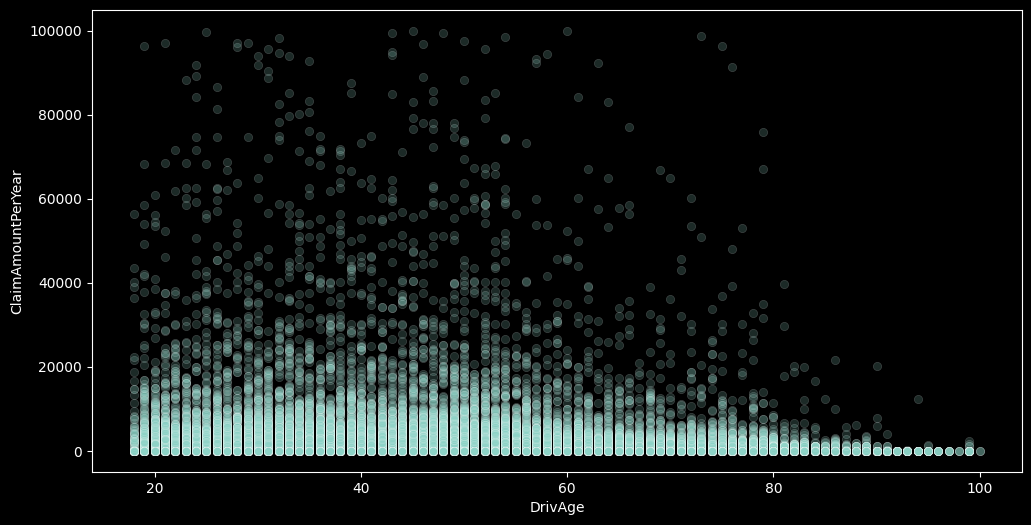

In [44]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='DrivAge', y='ClaimAmountPerYear', data=df_merged, alpha=0.2);

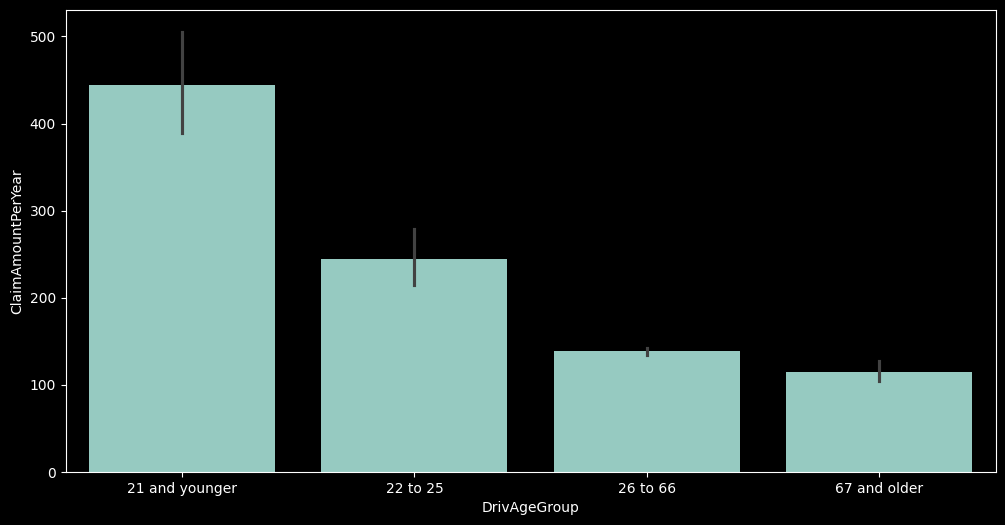

In [22]:
plt.figure(figsize=(12,6))
df_merged['DrivAgeGroup'] = pd.cut(df_merged['DrivAge'], [18, 21, 25, 66, max(df_merged['DrivAge'])], include_lowest=True,
                                   labels=['21 and younger', '22 to 25', '26 to 66', '67 and older'],  precision=0)
ax = sns.barplot(x='DrivAgeGroup', y='ClaimAmountPerYear', data=df_merged);

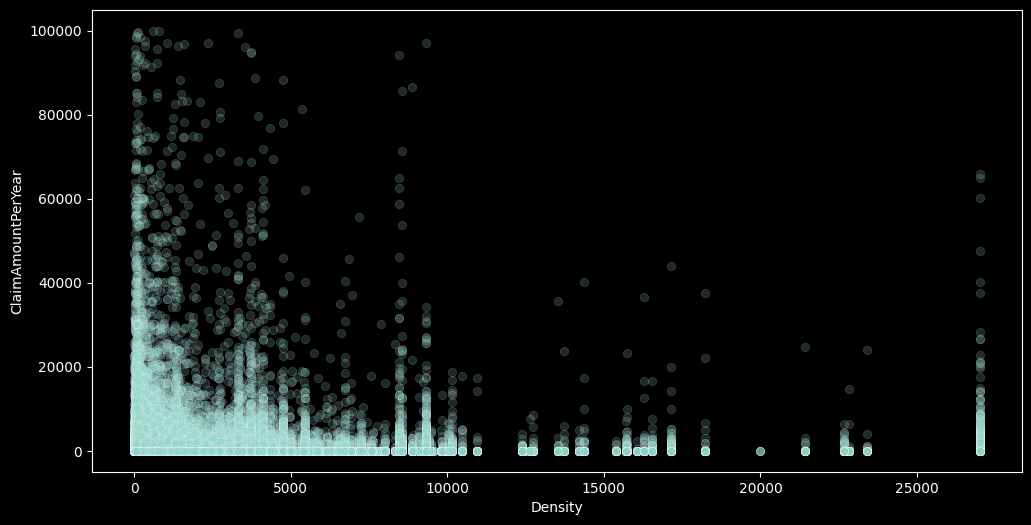

In [119]:
plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='Density', y='ClaimAmountPerYear', data=df_merged, alpha=0.2);

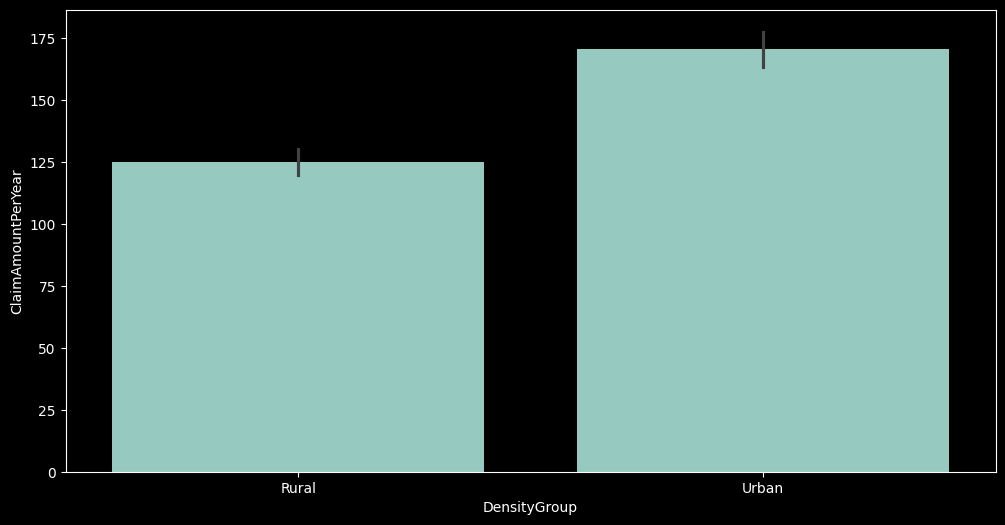

In [23]:
plt.figure(figsize=(12,6))
df_merged['DensityGroup'] = pd.cut(df_merged['Density'], [0, 500, max(df_merged['Density'])], include_lowest=True,
                                  labels=['Rural', 'Urban'],  precision=0)
ax = sns.barplot(x='DensityGroup', y='ClaimAmountPerYear', data=df_merged);

In [14]:
corr_matrix = df_merged[num_cols].corr()
corr_matrix

,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmountPerYear
VehPower,1.000000,-0.006026,0.030102,-0.075894,0.042918,0.002222
VehAge,-0.006026,1.000000,-0.059219,0.079862,-0.090434,0.003460
DrivAge,0.030102,-0.059219,1.000000,-0.479841,-0.004721,-0.013548
BonusMalus,-0.075894,0.079862,-0.479841,1.000000,0.077772,0.037521
Density,0.042918,-0.090434,-0.004721,0.077772,1.000000,0.005312
ClaimAmountPerYear,0.002222,0.003460,-0.013548,0.037521,0.005312,1.000000


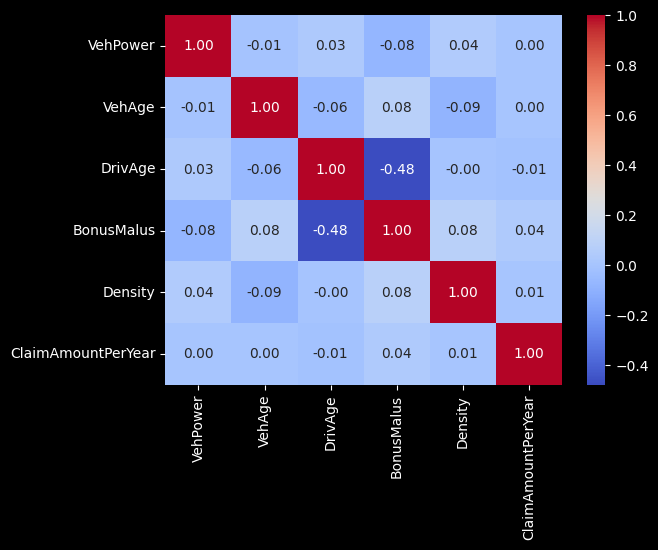

In [15]:
plot = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

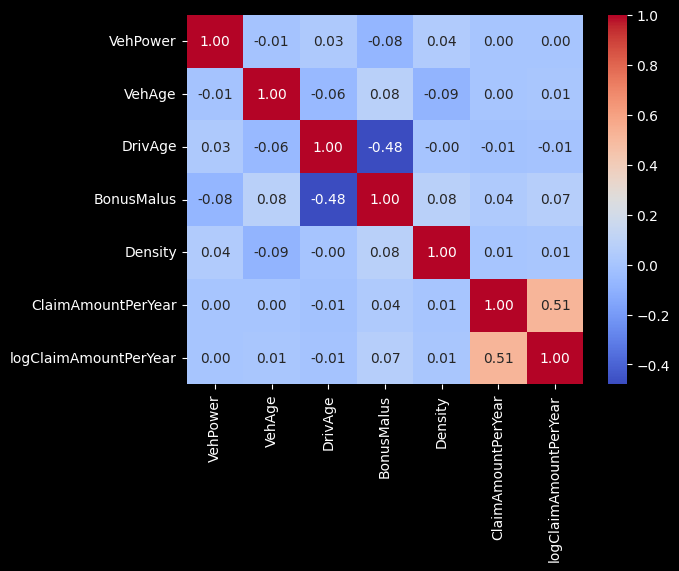

In [19]:
df_merged['logClaimAmountPerYear'] = np.log(df_merged['ClaimAmountPerYear'] + 1)
corr_matrix = df_merged[num_cols + ['logClaimAmountPerYear']].corr()
plot = sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')

### Modellvergleich und Modellbuilding

In [26]:
TRAIN_SHARE = 0.9
df_train = df_merged.sample(frac=TRAIN_SHARE, random_state=0).reset_index(drop=True)
df_test = df_merged.drop(df_train.index).reset_index(drop=True)

In [25]:
y_train, X_train = dmatrices('ClaimAmountPerYear ~ Area + VehPower + VehAge + DrivAge + DrivAge + BonusMalus + VehBrand + VehGas + Density + Region', data=df_train, return_type='dataframe')
y_test, X_test = dmatrices('ClaimAmountPerYear ~ Area + VehPower + VehAge + DrivAge + DrivAge + BonusMalus + VehBrand + VehGas + Density + Region', data=df_test, return_type='dataframe')

#### OLS regression

In [27]:
ols_cont = OLS(y_train, X_train)

res_ols_cont = ols_cont.fit()

res_ols_cont.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ClaimAmountPerYear   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     26.96
Date:                Sun, 18 Aug 2024   Prob (F-statistic):          9.68e-210
Time:                        12:55:30   Log-Likelihood:            -5.4377e+06
No. Observations:              609967   AIC:                         1.088e+07
Df Residuals:                  609924   BIC:                         1.088e+07
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -222.2459     21.804    -10.193      0.000    -264.981    -179.510
Area[T.B]            20.3365      9.203      2.210      0.027       2.299      38.374
Area[T.C]            15.5105      7.643      2.029      0.042       0.530      30.491
Area[T.D]            40.5643      8.355      4.855      0.000      24.189      56.940
Area[T.E]            46.9586     11.296      4.157      0.000      24.820      69.097
Area[T.F]            41.2340     40.764      1.012      0.312     -38.662     121.130
VehBrand[T.B10]       0.4122     15.448      0.027      0.979     -29.865      30.690
VehBrand[T.B11]      15.6136     17.306      0.902      0.367     -18.306      49.533
VehBrand[T.B12]     -52.7533      7.661     -6.886      0.000     -67.769     -37.737
VehBrand[T.B13]      -6.2146     17.979     -0.346      0.730     -41.452      29.023
VehBrand[T.B14]     -31.6496     30.275     -1.045      0.296     -90.987      27.688
VehBrand[T.B2]       -0.3350      6.700     -0.050      0.960     -13.466      12.796
VehBrand[T.B3]        4.9821      9.548      0.522      0.602     -13.731      23.696
VehBrand[T.B4]       -4.3607     12.903     -0.338      0.735     -29.650      20.929
VehBrand[T.B5]       34.9438     11.242      3.108      0.002      12.910      56.978
VehBrand[T.B6]        3.2948     12.226      0.269      0.788     -20.668      27.258
VehGas[T.Regular]   -15.8201      4.790     -3.303      0.001     -25.209      -6.432
Region[T.R21]       -34.5723     35.684     -0.969      0.333    -104.512      35.368
Region[T.R22]        17.2613     23.039      0.749      0.454     -27.894      62.416
Region[T.R23]       -19.8799     22.053     -0.901      0.367     -63.104      23.344
Region[T.R24]        12.1182     10.861      1.116      0.265      -9.169      33.405
Region[T.R25]         0.1240     20.379      0.006      0.995     -39.819      40.067
Region[T.R26]        -2.1750     20.719     -0.105      0.916     -42.783      38.433
Region[T.R31]       -15.7497     14.466     -1.089      0.276     -44.103      12.603
Region[T.R41]         6.2920     19.033      0.331      0.741     -31.013      43.597
Region[T.R42]         8.9800     41.599      0.216      0.829     -72.553      90.513
Region[T.R43]        32.7358     52.955      0.618      0.536     -71.055     136.527
Region[T.R52]        10.6666     13.259      0.805      0.421     -15.320      36.653
Region[T.R53]        22.8418     13.232      1.726      0.084      -3.092      48.775
Region[T.R54]        21.6058     16.704      1.293      0.196     -11.134      54.345
Region[T.R72]        32.1454     13.912      2.311      0.021       4.879      59.412
Region[T.R73]       -39.1640     16.946     -2.311      0.021     -72.378      -5.950
Region[T.R74]        40.9029     29.620      1.381      0.167     -17.151

In [28]:
pred_ols_cont = res_ols_cont.predict(X_test)

# calculate RMSE
rmse_ols_cont = np.sqrt(np.mean((pred_ols_cont - y_test['ClaimAmountPerYear']) ** 2))
print(f'RMSE: {rmse_ols_cont:.2f}')

RMSE: 1597.84


In [29]:
y_train, X_train = dmatrices('ClaimAmountPerYear ~ Area + VehPower + VehAgeGroup + DrivAgeGroup + BonusMalus + VehBrand + VehGas + DensityGroup + Region', data=df_train, return_type='dataframe')
y_test, X_test = dmatrices('ClaimAmountPerYear ~ Area + VehPower + VehAgeGroup + DrivAgeGroup + BonusMalus + VehBrand + VehGas + DensityGroup + Region', data=df_test, return_type='dataframe')

In [30]:
ols_cat = OLS(y_train, X_train)

res_ols_cat = ols_cat.fit()

res_ols_cat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     ClaimAmountPerYear   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     25.78
Date:                Sun, 18 Aug 2024   Prob (F-statistic):          5.15e-218
Time:                        12:55:49   Log-Likelihood:            -5.4376e+06
No. Observations:              609967   AIC:                         1.088e+07
Df Residuals:                  609920   BIC:                         1.088e+07
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 16.9798     28.303      0.600      0.549     -38.493      72.453
Area[T.B]                                 19.9854      9.201      2.172      0.030       1.951      38.020
Area[T.C]                                 15.7435      7.635      2.062      0.039       0.779      30.708
Area[T.D]                                -96.1537    191.190     -0.503      0.615    -470.880     278.573
Area[T.E]                                -88.4457    191.328     -0.462      0.644    -463.442     286.551
Area[T.F]                                -89.4081    191.958     -0.466      0.641    -465.639     286.823
VehAgeGroup[T.used and older vehicles]     1.1686      5.328      0.219      0.826      -9.274      11.611
VehAgeGroup[T.newtimers]                 -67.8787     22.817     -2.975      0.003    -112.600     -23.158
VehAgeGroup[T.oldtimers]                 -65.9768     57.407     -1.149      0.250    -178.493      46.540
DrivAgeGroup[T.22 to 25]                -161.7992     21.292     -7.599      0.000    -203.531    -120.067
DrivAgeGroup[T.26 to 66]                -163.5690     19.139     -8.546      0.000    -201.082    -126.056
DrivAgeGroup[T.67 and older]            -152.6571     20.793     -7.342      0.000    -193.411    -111.903
VehBrand[T.B10]                            4.4160     15.460      0.286      0.775     -25.886      34.717
VehBrand[T.B11]                           14.8695     17.302      0.859      0.390     -19.042      48.781
VehBrand[T.B12]                          -41.9362      7.668     -5.469      0.000     -56.966     -26.906
VehBrand[T.B13]                           -4.8572     17.976     -0.270      0.787     -40.090      30.375
VehBrand[T.B14]                          -31.6963     30.273     -1.047      0.295     -91.031      27.638
VehBrand[T.B2]                            -0.5063      6.701     -0.076      0.940     -13.641      12.628
VehBrand[T.B3]                             2.9610      9.536      0.311      0.756     -15.729      21.652
VehBrand[T.B4]                            -5.3404     12.887     -0.414      0.679     -30.599      19.918
VehBrand[T.B5]                            34.9191     11.241      3.106      0.002      12.887      56.952
VehBrand[T.B6]                             3.6443     12.216      0.298      0.765     -20.299      27.588
VehGas[T.Regular]                        -17.4496      4.760     -3.666      0.000     -26.779      -8.120
DensityGroup[T.Urban]                    138.0809    191.144      0.722      0.470    -236.555     512.716
Region[T.R21]                            -34.6062     35.673     -0.970      0.332    -104.524      35.311
Region[T.R22]                             16.3338     22.988      0.711      0.477     

In [31]:
pred_ols_cat = res_ols_cat.predict(X_test)

# calculate RMSE
rmse_ols_cat = np.sqrt(np.mean((pred_ols_cat - y_test['ClaimAmountPerYear']) ** 2))
print(f'RMSE: {rmse_ols_cat:.2f}')

RMSE: 1597.70


#### Decision Tree

In [32]:
from sklearn.tree import DecisionTreeRegressor

In [33]:
tree_2 = DecisionTreeRegressor(max_depth=2)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_2.fit(X_train, y_train)
tree_5.fit(X_train, y_train);

In [34]:
# calculate RMSE for tree with max_depth=2
pred_tree_2 = tree_2.predict(X_test)
rmse_tree_2 = np.sqrt(np.mean((pred_tree_2 - y_test['ClaimAmountPerYear']) ** 2))

# calculate RMSE for tree with max_depth=5
pred_tree_5 = tree_5.predict(X_test)
rmse_tree_5 = np.sqrt(np.mean((pred_tree_5 - y_test['ClaimAmountPerYear']) ** 2))


print(f'RMSE for tree with max_depth=2: {rmse_tree_2:.2f}')
print(f'RMSE for tree with max_depth=5: {rmse_tree_5:.2f}')

RMSE for tree with max_depth=2: 1598.13
RMSE for tree with max_depth=5: 1597.59


#### XGBoost

In [35]:
from xgboost import XGBRegressor

In [36]:
# REMOVE [] FROM COLUMN NAMES
new_cols = [i.replace('[', '(').replace(']', ')') for i in X_train.columns]
X_train.columns = new_cols
X_test.columns = new_cols

In [37]:
model = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [38]:
preds_xgb = model.predict(X_test)

rmse_xgb = np.sqrt(np.mean((preds_xgb - y_test['ClaimAmountPerYear']) ** 2))
print(f'RMSE: {rmse_xgb:.2f}')

RMSE: 1548.88


#### K Nearest Neighbors

In [58]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X_train, y_train)

KNeighborsRegressor()

In [59]:
samples = 5_000
neigh_preds_all = np.zeros(len(X_test))
# make predictions in batches to avoid memory errors
for i in range(0, len(X_test), samples):
    neigh_preds = neigh.predict(X_test.iloc[i:i+samples])
    neigh_preds_all[i:i+samples] = neigh_preds.reshape(-1)
rmse_neigh = np.sqrt(np.mean((neigh_preds_all - y_test['ClaimAmountPerYear']) ** 2))
print(f'RMSE: {rmse_neigh:.2f}')

RMSE: 1578.57


In [54]:
# calculate rmse for always predicting 0
# rmse_0 = np.sqrt(np.mean(df_merged["ClaimAmountPerYear"] ** 2))
# print(f"RMSE for predicting 0 for all contracts: {rmse_0:.2f}")

# rmse for always predicting the mean
rmse_mean = np.sqrt(np.mean((df_merged["ClaimAmountPerYear"] - df_merged["ClaimAmountPerYear"].mean()) ** 2))
print(f"RMSE for predicting the mean for all contracts: {rmse_mean:.2f}")

RMSE for predicting the mean for all contracts: 1798.35


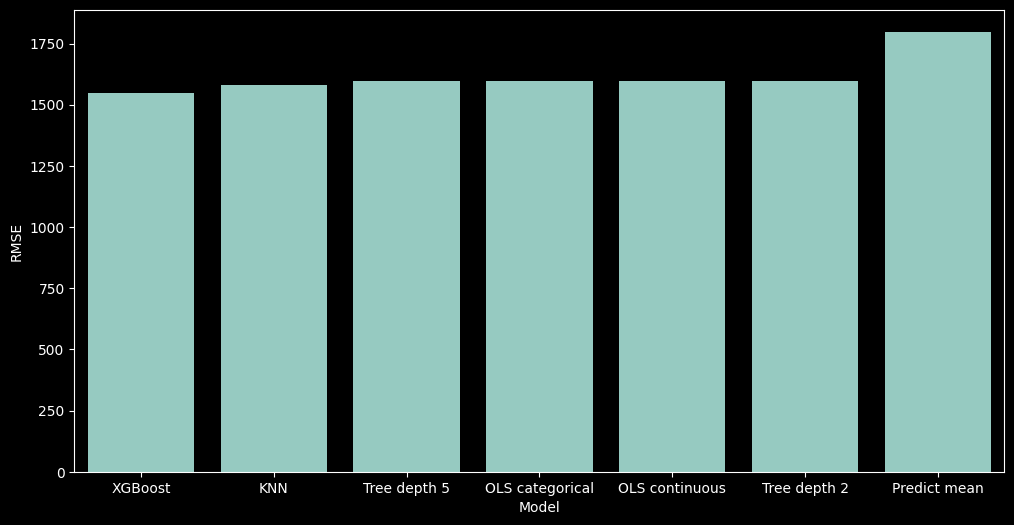

In [60]:
# compare RMSEs
# create a dictionary with the RMSEs
rmse_dict = {'OLS continuous': rmse_ols_cont, 'OLS categorical': rmse_ols_cat, 'Tree depth 2': rmse_tree_2, 
             'Tree depth 5': rmse_tree_5, 'XGBoost': rmse_xgb, 'KNN': rmse_neigh, 'Predict mean': rmse_mean}

# create a DataFrame from the dictionary
rmse_df = pd.DataFrame(rmse_dict.items(), columns=['Model', 'RMSE'])

# sort the DataFrame by RMSE
rmse_df = rmse_df.sort_values('RMSE')

# plot the RMSEs
plt.figure(figsize=(12, 6))

sns.barplot(x='Model', y='RMSE', data=rmse_df);
